<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 6>Finding the best place to open Yoga Studio<br><font size = 5>(Manhattan, New York City)</font></h1>

## 0. Python Libraries

At the beginning we are installing geopy and folium packages to python.

In [48]:
!pip install geopy
!pip install folium
!pip install shapely

     |████████████████████████████████| 1.5MB 28.7MB/s 


It is necessary to import all libraries which we will use.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

We downloads data from server.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [7]:
# import the population csv data
    
!wget --quiet -O manData.csv "https://drive.google.com/uc?authuser=0&id=1bbDj9qo2OF4g9rSgNW6VrXK3FUbn_hjV&export=download"

df_man = pd.read_csv('manData.csv')
print(df_man.shape)   
df_man.head()

(29, 6)


,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Manhattan,2010,61,MN01,Marble Hill-Inwood,46746
1,Manhattan,2010,61,MN03,Central Harlem North-Polo Grounds,75282
2,Manhattan,2010,61,MN04,Hamilton Heights,48520
3,Manhattan,2010,61,MN06,Manhattanville,22950
4,Manhattan,2010,61,MN09,Morningside Heights,55929


In [8]:
address = 'Manhattan, New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
mLat = location.latitude
mLon = location.longitude
print('The geograpical coordinate of Manhattan, New York City are {}, {}.'.format(mLat, mLon))

The geograpical coordinate of Manhattan, New York City are 40.7896239, -73.9598939.


In [9]:
# download brough boundary of Manhattan
!wget --quiet -O man.json "https://drive.google.com/uc?authuser=0&id=1NIduULTbs3o73tlQV_Y2xkyQQQKs29PV&export=download"
man_geo = r'man.json'

print('Manhattan GeoJSON file downloaded!')
man_geo

Manhattan GeoJSON file downloaded!


'man.json'

In [10]:
# prepare a choropleth map centered around Manhattan
import json

man_map = folium.Map(location=[mLat, mLon], zoom_start=11,  tiles='cartodbpositron')
# generate choropleth map
folium.Choropleth(
    geo_data=man_geo,
    data=df_man,
    columns=['NTA Code', 'Population'],
    key_on='feature.properties.ntacode',
    fill_color='YlGnBu', 
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Population of Manhattan Neighborhoods'
).add_to(man_map)




man_map

In [11]:
#matplotlib library
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Matplotlib version:  1.5.3


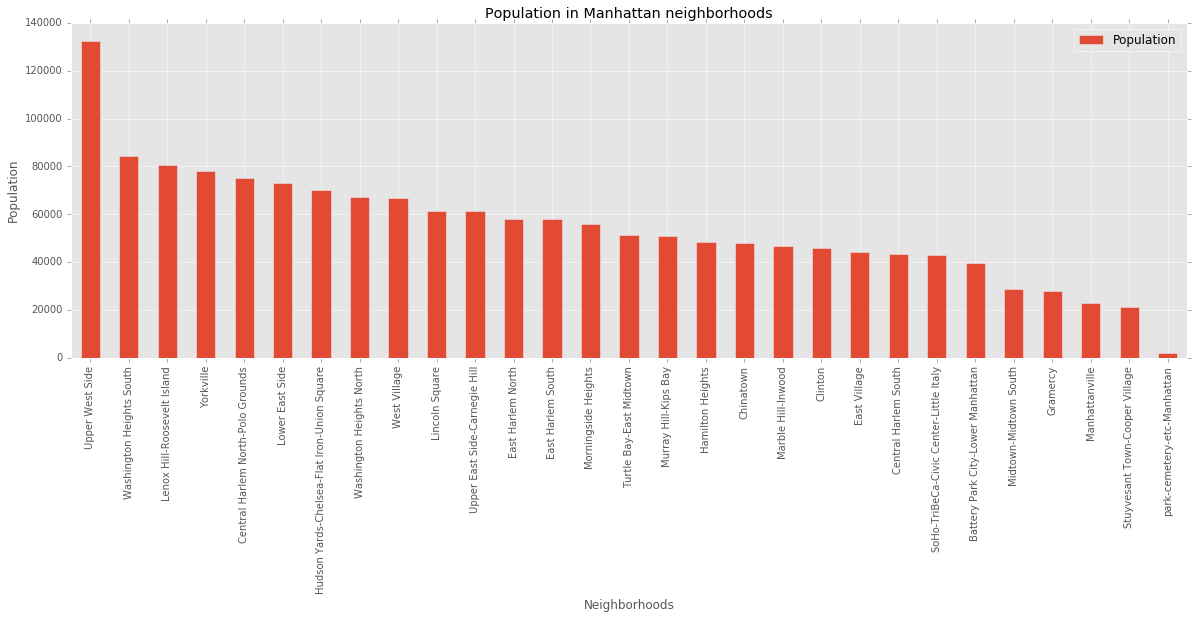

In [12]:
# prepare the dsataset
df_manpop = df_man.copy()
columns = ['Year', 'FIPS County Code', 'Borough', 'NTA Code']
df_manpop.drop(columns, inplace=True, axis=1)
df_manpop.set_index('NTA Name', inplace=True)
df_manpop = df_manpop.sort_values(by=['Population'], ascending=False)
# plot data
df_manpop.plot(kind='bar', figsize=(20, 6))
plt.xlabel('Neighborhoods') # add x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Population in Manhattan neighborhoods')

plt.show()

In [13]:
import math
def measure(lat1, lon1, lat2, lon2):
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180;
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180;
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return round(d * 1000)/2 # meters


In [14]:
with open('man.json') as f:
    data = json.load(f)
    
from shapely.wkt import loads as load_wkt
from shapely.geometry import MultiPolygon

import json
from shapely.geometry import shape, GeometryCollection

# NOTE: buffer(0) is a trick for fixing scenarios where polygons have overlapping coordinates 
#gc = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])




df = pd.DataFrame(columns=['NTA Code', 'Latitude', 'Longitude','Radius (meters)', 'Polygon'] )
for feature in data['features']:
    ntacode = feature['properties']['ntacode']
    #print(feature['properties'])
    
    
    #Get centroid of MultiPolygon
    lat = shape(feature["geometry"]).buffer(0).centroid.coords[0][1]
    lng = shape(feature["geometry"]).buffer(0).centroid.coords[0][0]
    pol = shape(feature["geometry"]).buffer(0)
    
    b = pol.bounds
    
    radius = max(measure(b[0],0,b[2],0), measure(0,b[1],0,b[3]))
    #print(o)
    
    df = df.append({
            'NTA Code' : ntacode,
            'Latitude' : lat,
            'Longitude' : lng,
            'Radius (meters)': radius,
            'Polygon': pol
        }, ignore_index=True)
print(df.shape)    
df.head()

(29, 5)


,NTA Code,Latitude,Longitude,Radius (meters),Polygon
0,MN99,40.787978,-73.954782,10912.0,"(POLYGON ((-73.926406 40.877621, -73.926351 40..."
1,MN25,40.708002,-74.010235,1395.0,"(POLYGON ((-73.99476900000001 40.703953, -73.9..."
2,MN01,40.867907,-73.917654,1301.0,"(POLYGON ((-73.906651 40.875753, -73.906917000..."
3,MN40,40.774730,-73.961174,1467.5,"POLYGON ((-73.949332 40.785193, -73.9498240000..."
4,MN32,40.777316,-73.948706,1096.0,"(POLYGON ((-73.938046 40.78083, -73.937901 40...."


In [19]:
df2 = df.copy()

#df2.join(df_man.set_index('NTA Code'), on='NTA Code')

df2 = df2.set_index('NTA Code').join(df_man.set_index('NTA Code'), how='outer').reset_index()

print(df2.shape)   
df2

(29, 10)


,NTA Code,Latitude,Longitude,Radius (meters),Polygon,Borough,Year,FIPS County Code,NTA Name,Population
0,MN01,40.867907,-73.917654,1301.0,"(POLYGON ((-73.906651 40.875753, -73.906917000...",Manhattan,2010,61,Marble Hill-Inwood,46746
1,MN03,40.818258,-73.940771,1696.0,"POLYGON ((-73.93383 40.819491, -73.934117 40.8...",Manhattan,2010,61,Central Harlem North-Polo Grounds,75282
2,MN04,40.827013,-73.948522,1164.0,"POLYGON ((-73.94034600000001 40.830458, -73.94...",Manhattan,2010,61,Hamilton Heights,48520
3,MN06,40.817976,-73.953782,888.0,"POLYGON ((-73.946078 40.821263, -73.946403 40....",Manhattan,2010,61,Manhattanville,22950
4,MN09,40.807886,-73.962543,1156.0,"POLYGON ((-73.952101 40.811443, -73.952591 40....",Manhattan,2010,61,Morningside Heights,55929
5,MN11,40.804332,-73.951292,995.0,"POLYGON ((-73.941771 40.807089, -73.942263 40....",Manhattan,2010,61,Central Harlem South,43383
6,MN12,40.790381,-73.973907,1564.0,"POLYGON ((-73.96003 40.798038, -73.96052299999...",Manhattan,2010,61,Upper West Side,132378
7,MN13,40.747582,-73.999009,1572.0,"POLYGON ((-74.00153299999999 40.762645, -74.00...",Manhattan,2010,61,Hudson Yards-Chelsea-Flat Iron-Union Square,70150
8,MN14,40.774847,-73.984699,1182.5,"POLYGON ((-73.974997 40.777533, -73.975459 40....",Manhattan,2010,61,Lincoln Square,61489
9,MN15,40.764176,-73.992397,1190.5,"POLYGON ((-73.993831 40.772932, -73.993787 40....",Manhattan,2010,61,Clinton,45884


MN33


'MN33'

In [16]:
# prepare a choropleth map centered around Manhattan
import json
#tiles='Mapbox Bright'
man_map = folium.Map(location=[mLat, mLon], zoom_start=11, tiles='cartodbpositron')
# generate choropleth map
folium.Choropleth(
    geo_data=man_geo,
    data=df_man,
    columns=['NTA Code', 'Population'],
    key_on='feature.properties.ntacode',
    fill_color='YlGnBu',
    fill_opacity=0.2, 
    line_opacity=0.2,
    legend_name='Population of Manhattan Neighborhoods'
).add_to(man_map)

for lat, lng, rad, name in zip(df2['Latitude'], df2['Longitude'], df2['Radius (meters)'], df2['NTA Name']):
    #label = '{}, {}'.format(clabels, "aa")
    #label = folium.Popup(label, parse_html=True)
        
    folium.Circle(
        [lat, lng],
        radius=rad,
        #popup=label,
        color='black',
        opacity=0.2,
        fill=True,
        fill_color='red',
        fill_opacity=0,
        parse_html=False).add_to(man_map) 

man_map

## Foursquare API
We will connect to Foursquare API via credentials and load all data we need.

In [23]:
CLIENT_ID = 'EJCQWYHVCHNTPBQIRO5AS3JDCRWELWCTRQ04MLO5L2VFJ0R1' # your Foursquare ID
CLIENT_SECRET = '5OC1XWIM3WCSZYJUQOFGQCTS4JAEILPA3BCIYOQTTJZN4E3W' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EJCQWYHVCHNTPBQIRO5AS3JDCRWELWCTRQ04MLO5L2VFJ0R1
CLIENT_SECRET:5OC1XWIM3WCSZYJUQOFGQCTS4JAEILPA3BCIYOQTTJZN4E3W


In [24]:
all_venues_list = []
def getNearbyVenues(ntacode, latitudes, longitudes, radius):
    
    
    for ntacode, lat, lng, radius in zip(ntacode, latitudes, longitudes, radius):
        print(ntacode)
            
        LIMIT = 100 # limit of number of venues returned by Foursquare API
        radius = radius # define radius
        category = "4bf58dd8d48988d102941735" #YOHA STUDIO
        #category = "4bf58dd8d48988d175941735" #GYM
        #category = "4d4b7105d754a06374d81259" #FOOD
        #query =""
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category
            )
            
        # make the GET request
        venues = requests.get(url).json()["response"]['venues']
        if len(venues)>0:
            venue = requests.get(url).json()["response"]['venues'][0]
            
            for v in venues:
                            
                all_venues_list.append([ntacode,v['id'],v['location']['lat'],v['location']['lng'],v['name']])
        
    return#(nearby_venues)

# type your answer here

manhattan_venues = getNearbyVenues(ntacode=df2['NTA Code'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude'],
                                   radius=df2['Radius (meters)']
                                  )

MN01
MN03
MN04
MN06
MN09
MN11
MN12
MN13
MN14
MN15
MN17
MN19
MN20
MN21
MN22
MN23
MN24
MN25
MN27
MN28
MN31
MN32
MN33
MN34
MN35
MN36
MN40
MN50
MN99


We create new dataframe with Name, Cluster and ID of a Yoga Studio.

In [45]:
from shapely.wkt import loads as load_wkt
from shapely.geometry import MultiPolygon
from shapely.geometry import Point

def isPart(lat, lng):
    for p, k in zip(df['Polygon'], df['NTA Code']):
            if p.contains(Point(lat, lng)) == True:
                return k
    return None

def getPointsNTD(id, lat, lng):
    aa = []
    
    for id, lat, lng in zip(id, lat, lng):
        aa.append(isPart(lat,lng))                
    return aa        

In [46]:
avl = pd.DataFrame(all_venues_list, columns = ['NTA Code','ID','Latitude','Longitude', 'Name'])

#avl.insert(0, 'New Code', '')

avl = avl.sort_values(by=['ID'], ascending=False)
avl.drop_duplicates(subset ="ID", keep = "first", inplace = True)

avl['NTA Code'] = getPointsNTD(id=avl['ID'], lat=avl['Longitude'], lng=avl['Latitude'])
print(avl.shape)
avl.head()


(349, 5)


,NTA Code,ID,Latitude,Longitude,Name
41,MN03,5d93759594528b0008759ac9,40.812435,-73.951035,Bread & Yoga
620,None,5d7d09f1d13342000841d6c7,40.715968,-73.959723,Alo Yoga
700,MN40,5d60ee764d67cb00088e3df0,40.778481,-73.956128,CorePower Yoga
527,MN25,5d4cb3c1a2db240008311404,40.709784,-74.006837,Yogacare
327,MN17,5d23d10564380300238b01be,40.757163,-73.981805,BurnStrong


In [48]:
pa = pd.DataFrame(avl, columns = ['NTA Code','ID','Latitude','Longitude'])
#pa.drop_duplicates(subset ="ID", keep = False, inplace = True)
pa = pa.groupby('NTA Code').count().reset_index()
pa = pa.drop('Latitude', 1)
pa = pa.drop('Longitude', 1)
#pa = pa['NTA Code'] == "MN99"
#pa.set_index('NTA Code', inplace=True)

pa.rename(columns={"ID": "Num of Yoga studios"}, inplace=True)
print(pa.shape)
pa

(27, 2)


,NTA Code,Num of Yoga studios
0,MN01,1
1,MN03,4
2,MN04,4
3,MN06,3
4,MN09,2
5,MN11,5
6,MN12,15
7,MN13,40
8,MN14,19
9,MN15,6


In [49]:
df3 = df2.copy()

#df2.join(df_man.set_index('NTA Code'), on='NTA Code')

df3 = df3.set_index('NTA Code').join(pa.set_index('NTA Code') , how='outer').reset_index()
df3 = df3.drop('Borough', 1).drop('Year', 1).drop('FIPS County Code', 1)
df3 = df3.fillna(0)
df3.drop(df3.index[0], inplace=True)
print(df3.shape)
df3.head()


(28, 8)


,NTA Code,Latitude,Longitude,Radius (meters),Polygon,NTA Name,Population,Num of Yoga studios
1,MN03,40.818258,-73.940771,1696.0,"POLYGON ((-73.93383 40.819491, -73.934117 40.8...",Central Harlem North-Polo Grounds,75282,4.0
2,MN04,40.827013,-73.948522,1164.0,"POLYGON ((-73.94034600000001 40.830458, -73.94...",Hamilton Heights,48520,4.0
3,MN06,40.817976,-73.953782,888.0,"POLYGON ((-73.946078 40.821263, -73.946403 40....",Manhattanville,22950,3.0
4,MN09,40.807886,-73.962543,1156.0,"POLYGON ((-73.952101 40.811443, -73.952591 40....",Morningside Heights,55929,2.0
5,MN11,40.804332,-73.951292,995.0,"POLYGON ((-73.941771 40.807089, -73.942263 40....",Central Harlem South,43383,5.0


In [50]:
df4 = df3.copy()
df4.insert(0, 'Studios density (per 1000 inhabitants)', '')
df4['Studios density (per 1000 inhabitants)'] = round(df4['Num of Yoga studios']/df4['Population']*1000, 3)
#df4.apply(lambda row["New"]: row['Num of Yoga studios'] / row['Population'], axis=1)
df4.head()

,Studios density (per 1000 inhabitants),NTA Code,Latitude,Longitude,Radius (meters),Polygon,NTA Name,Population,Num of Yoga studios
1,0.053,MN03,40.818258,-73.940771,1696.0,"POLYGON ((-73.93383 40.819491, -73.934117 40.8...",Central Harlem North-Polo Grounds,75282,4.0
2,0.082,MN04,40.827013,-73.948522,1164.0,"POLYGON ((-73.94034600000001 40.830458, -73.94...",Hamilton Heights,48520,4.0
3,0.131,MN06,40.817976,-73.953782,888.0,"POLYGON ((-73.946078 40.821263, -73.946403 40....",Manhattanville,22950,3.0
4,0.036,MN09,40.807886,-73.962543,1156.0,"POLYGON ((-73.952101 40.811443, -73.952591 40....",Morningside Heights,55929,2.0
5,0.115,MN11,40.804332,-73.951292,995.0,"POLYGON ((-73.941771 40.807089, -73.942263 40....",Central Harlem South,43383,5.0


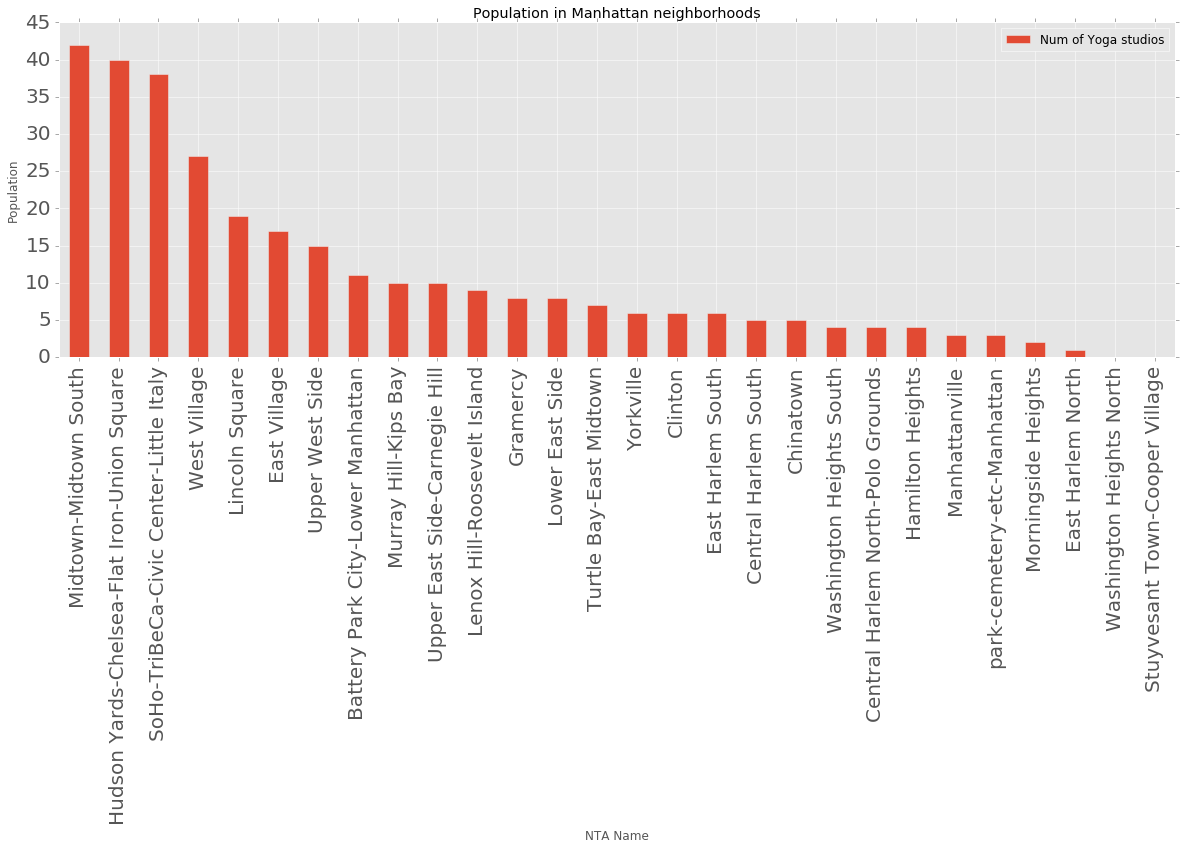

In [57]:
# prepare the dsataset
df5 = df4.copy()
df5 = df5.drop('Studios density (per 1000 inhabitants)', 1).drop('Latitude', 1).drop('Longitude', 1).drop('Radius (meters)', 1).drop('Population', 1)
df5 = df5.sort_values(by=['Num of Yoga studios'], ascending=False)
df5.set_index('NTA Name', inplace=True)
# plot data



df5.plot(kind='bar', figsize=(20, 6))
plt.xlabel('NTA Name') # add x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
plt.title('Population in Manhattan neighborhoods')

plt.show()

In [61]:
#The potential of in percents
numOfYogaConsumersKoef = 36.7/321
numOfYogaConsumersKoef

0.11433021806853584

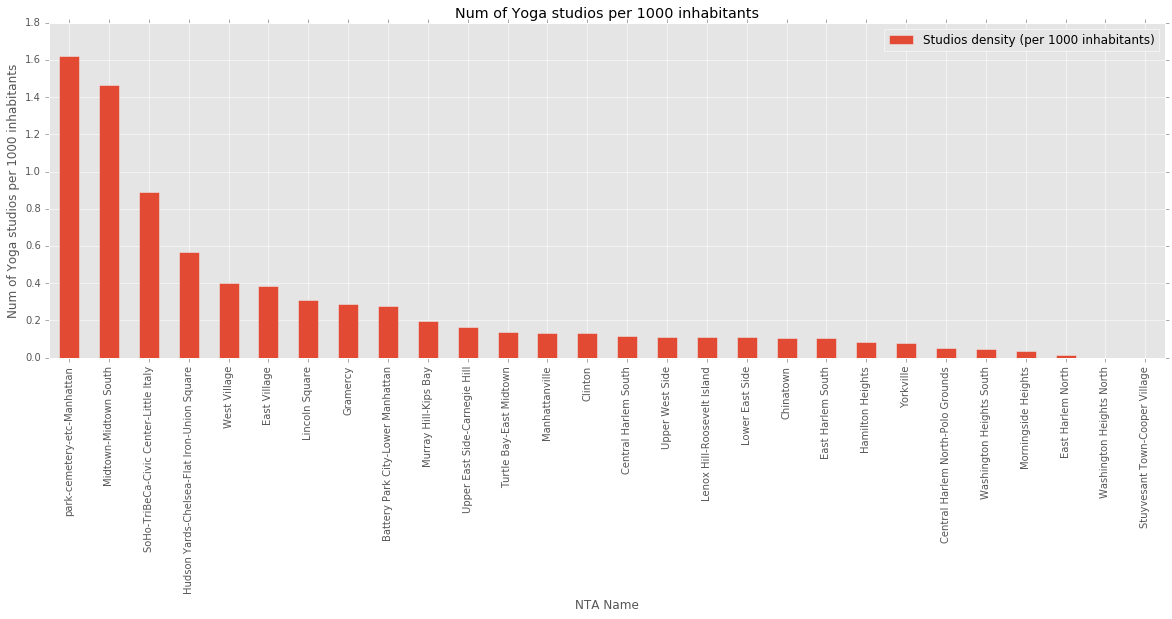

In [59]:
# prepare the dsataset
df6 = df4.copy()
df6 = df6.drop('Num of Yoga studios', 1).drop('Latitude', 1).drop('Longitude', 1).drop('Radius (meters)', 1).drop('Population', 1)
df6 = df6.sort_values(by=['Studios density (per 1000 inhabitants)'], ascending=False)
df6.set_index('NTA Name', inplace=True)
# plot data
df6.plot(kind='bar', figsize=(20, 6))
plt.xlabel('NTA Name') # add x-label to the plot
plt.ylabel('Num of Yoga studios per 1000 inhabitants') # add y-label to the plot
plt.title('Num of Yoga studios per 1000 inhabitants')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

plt.show()

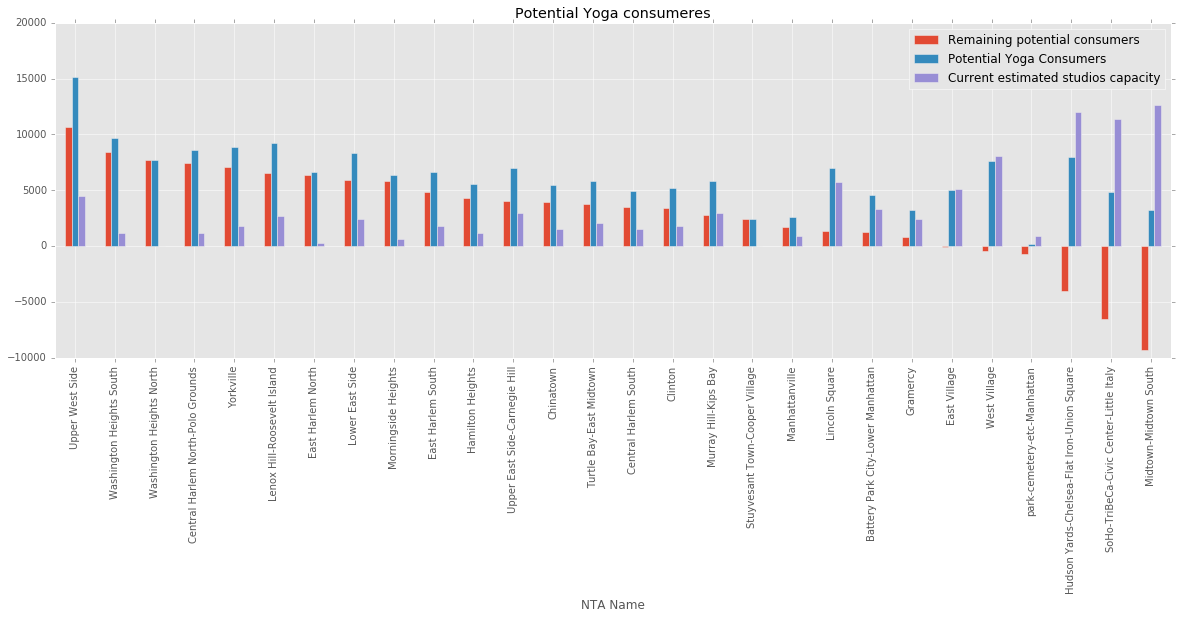

In [64]:
# prepare the dsataset
df6 = df4.copy()
df6 = df6.drop('Studios density (per 1000 inhabitants)', 1).drop('Latitude', 1).drop('Longitude', 1).drop('Radius (meters)', 1)
df6.insert(0, 'Remaining potential consumers', '')

df6['Population'] = df6['Population']*numOfYogaConsumersKoef
df6['Num of Yoga studios'] = df6['Num of Yoga studios']*300
df6['Remaining potential consumers'] = df6['Population']-df6['Num of Yoga studios']
df6.rename(columns={"Population": "Potential Yoga Consumers"}, inplace=True)
df6.rename(columns={"Num of Yoga studios": "Current estimated studios capacity"}, inplace=True)
df6 = df6.sort_values(by=['Remaining potential consumers'], ascending=False)
df6.set_index('NTA Name', inplace=True)
# plot data
df6.plot(kind='bar', figsize=(20, 6))
plt.xlabel('NTA Name') # add x-label to the plot
#plt.ylabel('Num of Yoga studios per 1000 inhabitants') # add y-label to the plot
plt.title('Potential Yoga consumeres')

plt.show()

In [65]:
# prepare a choropleth map centered around Manhattan
import json
df6 = df4.copy()
#df6 = df6.drop('Studios density (per 1000 inhabitants)', 1).drop('Latitude', 1).drop('Longitude', 1).drop('Radius (meters)', 1)
df6.insert(0, 'Remaining potential consumers', '')

df6['Population'] = df6['Population']*numOfYogaConsumersKoef
df6['Num of Yoga studios'] = df6['Num of Yoga studios']*300
df6['Remaining potential consumers'] = df6['Population']-df6['Num of Yoga studios']
df6.rename(columns={"Population": "Yoga Consumers"}, inplace=True)
df6 = df6.sort_values(by=['Remaining potential consumers'], ascending=False)

#tiles='Mapbox Bright'cartodbdark_matter
man_map = folium.Map(location=[mLat, mLon], zoom_start=11, tiles='cartodbpositron')
# generate choropleth map
folium.Choropleth(
    geo_data=man_geo,
    data=df6,
    popup='aa',
    columns=['NTA Code', 'Remaining potential consumers'],
    key_on='feature.properties.ntacode',
    fill_color='YlGnBu',
    fill_opacity=1, 
    line_opacity=0.2,
    legend_name='Remaining potential consumers'
).add_to(man_map)

for lat, lng, ntacode, ntaname, density, studioCount, population in zip(df4['Latitude'], df4['Longitude'], df4['NTA Code'], df4['NTA Name'], df4['Studios density (per 1000 inhabitants)'], df4['Num of Yoga studios'], df4['Population']):
    #label = 'Cluster {}, has {} Yoga Studios nearby.'.format(clabels, "a")
    #label = folium.Popup(label, parse_html=True)
    #print(lng)
    #if cluster  !=  17:
        #continue
    label = '<b>{}</b><br><br><b>Density:<br></b>{}<br>  <b>Number of studios:<br></b>{}<br>  <b>Population:<br></b>{}<br>'.format(ntaname,density, studioCount, population) 
    folium.Marker(
        [lat, lng],
        radius=1,
        icon=folium.Icon(icon='info-sign', color='blue'),
        popup=label,
        color='red',
        opacity=0.5,
        fill=True,
        fill_color='red',
        fill_opacity=1,
        parse_html=False).add_to(man_map)
man_map
 